# Two isoform DE

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [5]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to two isoform genes

In [6]:
gene = gene[:,gene.var["num_isoforms"]==2]

In [7]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 722 ms, sys: 142 ms, total: 865 ms
Wall time: 854 ms


In [8]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [9]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 6160 × 2654
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 6160 × 5308
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly

In [10]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [11]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster 0.75
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

18-Nov-20 19:09:38 - 1 of 2 assignments: GABAergic
18-Nov-20 19:09:39 - 2 of 2 assignments: Glutamatergic


CPU times: user 2.73 s, sys: 1.62 s, total: 4.35 s
Wall time: 4.34 s


In [12]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

18-Nov-20 19:10:09 - 1 of 2 assignments: GABAergic
18-Nov-20 19:10:10 - 2 of 2 assignments: Glutamatergic


CPU times: user 6.08 s, sys: 3.31 s, total: 9.4 s
Wall time: 9.38 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [13]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [14]:
setdiff.shape

(67,)

In [15]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es").tail()

,index,name,p_raw,p_corr,es,index_name
5671,Glutamatergic,Dnlz-201_ENSMUST00000028295,1.73545e-13,8.13924e-11,0.260686,Glutamatergic_Dnlz
9781,Glutamatergic,Polr2k-201_ENSMUST00000057177,3.75445e-09,1.76084e-06,0.271586,Glutamatergic_Polr2k
8022,Glutamatergic,Os9-201_ENSMUST00000080975,9.08423e-12,4.2605e-09,0.288732,Glutamatergic_Os9
8726,Glutamatergic,Ppib-202_ENSMUST00000213785,1.39731e-54,6.55339e-52,0.556182,Glutamatergic_Ppib
5653,Glutamatergic,Mrpl41-202_ENSMUST00000194392,2.67936e-82,1.25662e-79,0.864243,Glutamatergic_Mrpl41


In [16]:
specific_cluster = "Glutamatergic"
specific_isoform = "Ppib-202_ENSMUST00000213785"
specific_gene = "".join(specific_isoform.split("-")[0])
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene)].gene_name.values[0]

In [17]:
specific_gene

'Ppib_ENSMUSG00000032383'

In [18]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})

    
    return ax


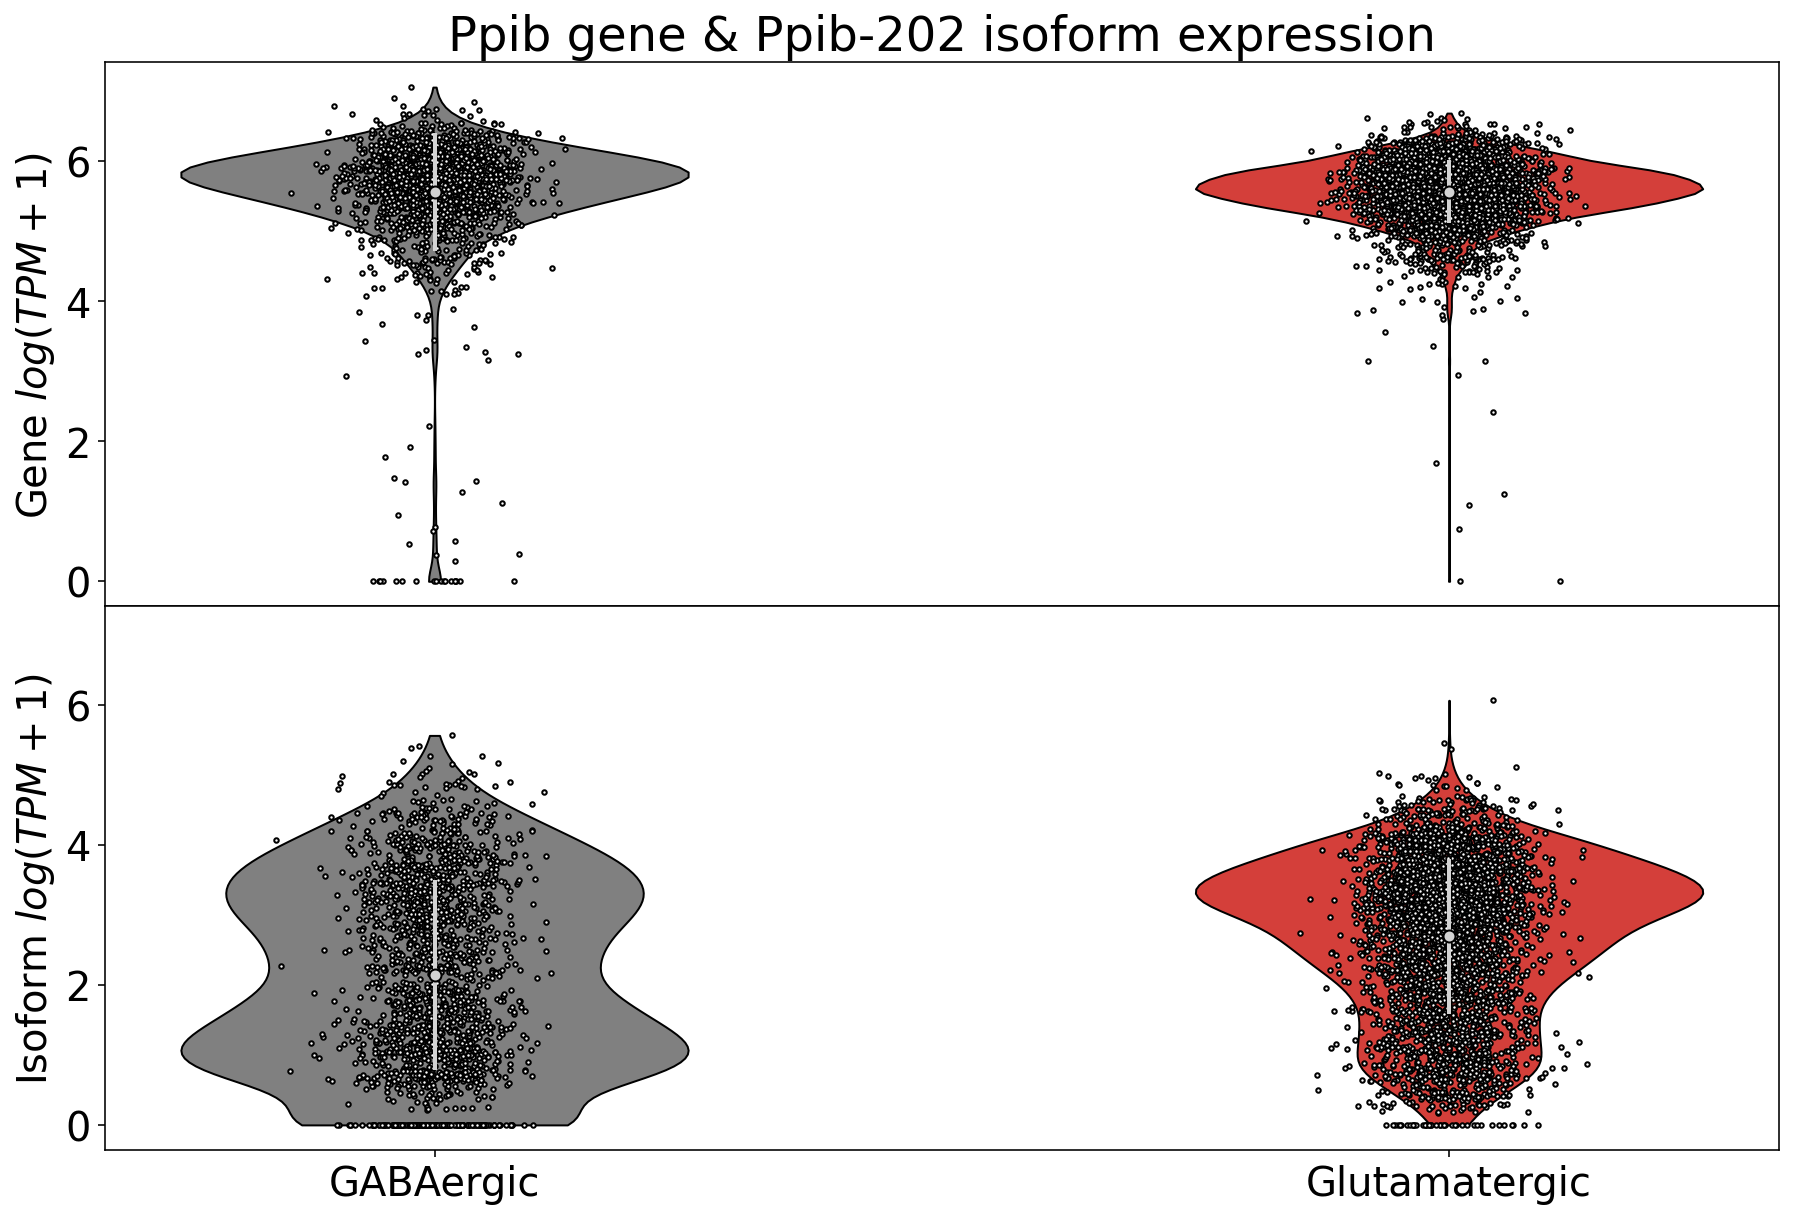

In [20]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label.astype(str)==c][:,gene.var.gene_name.astype(str)==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label.astype(str)==c][:,isoform.var.transcript_name.astype(str)==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})


plt.savefig(trackfig("../../figures/two_isoform_class_DE_violin_{}.png".format(specific_gene), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

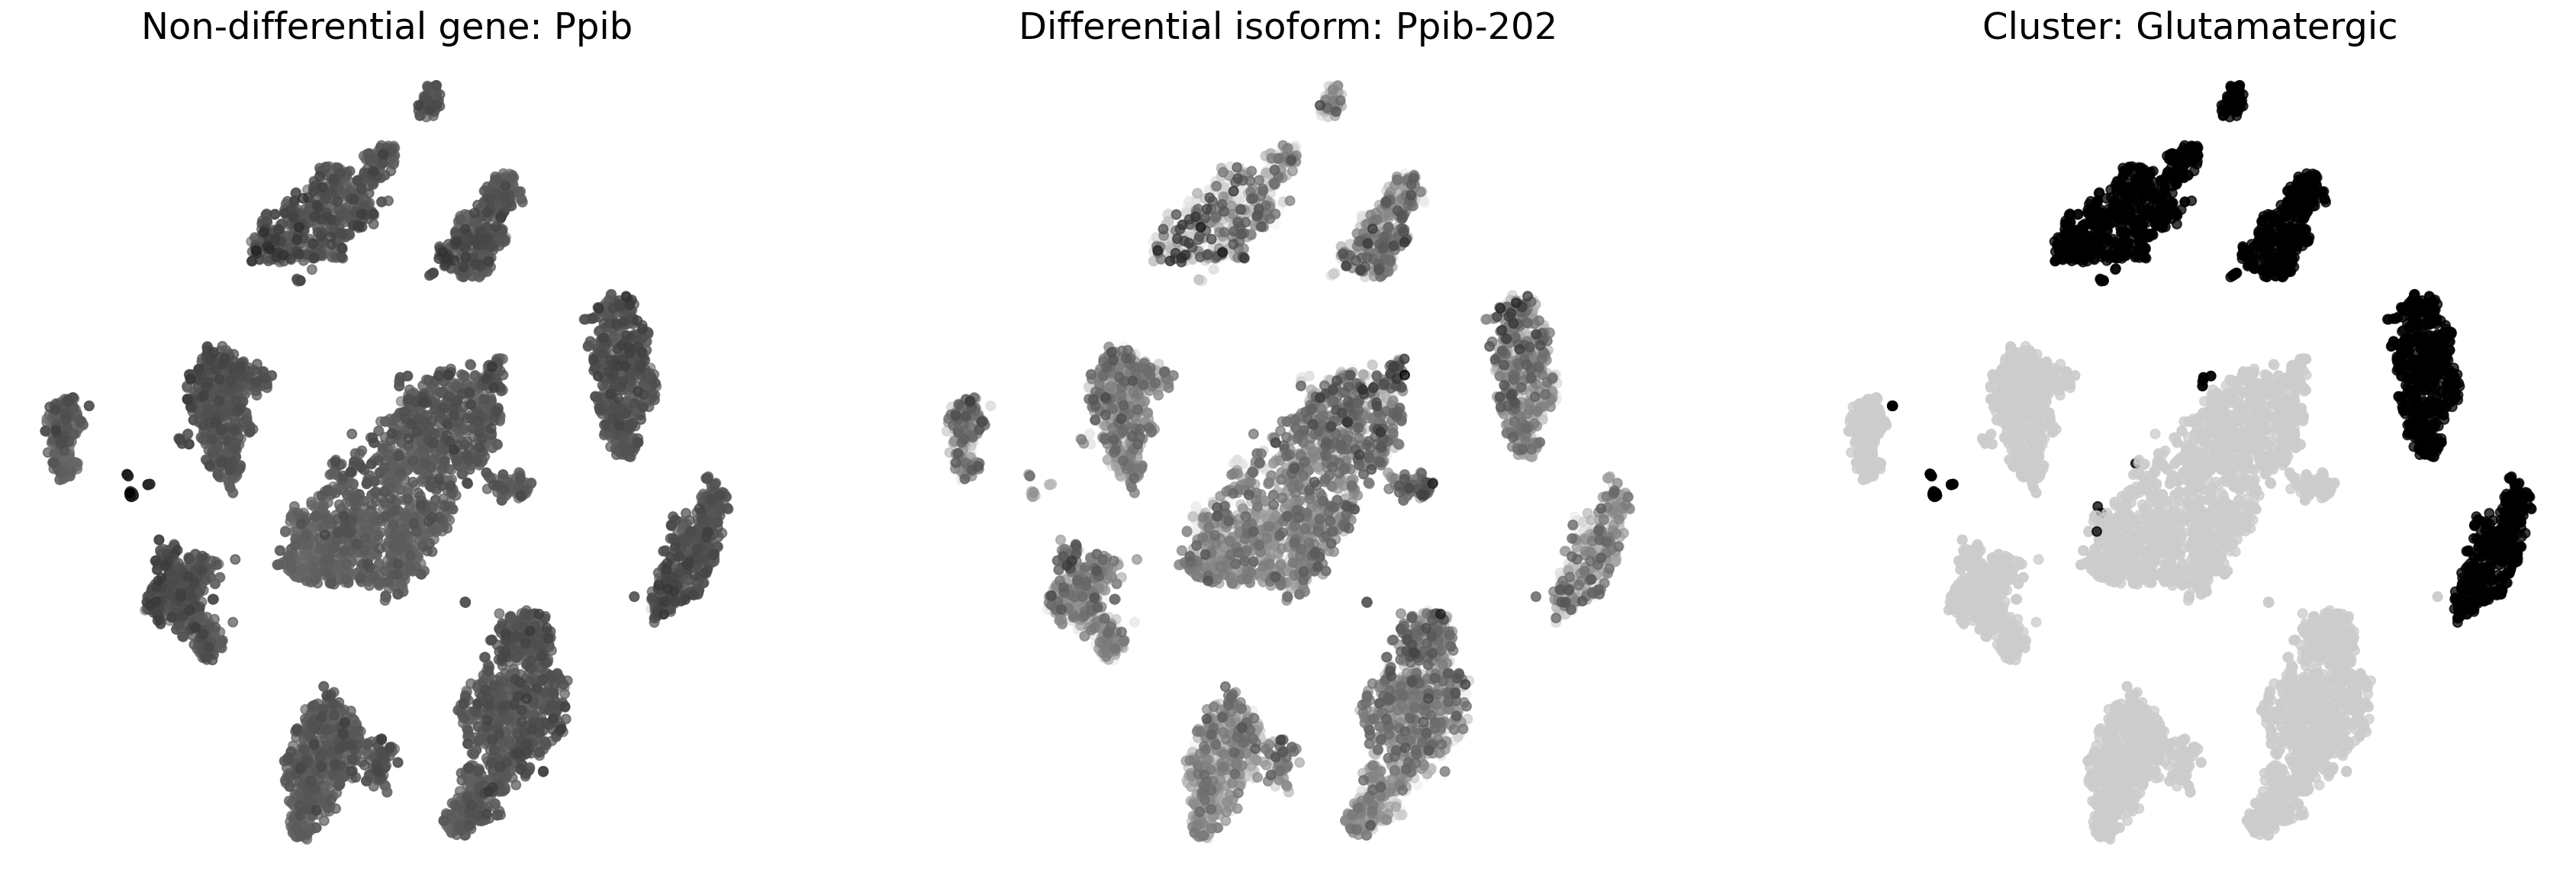

In [21]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort=np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort=np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
#c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["class_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig(trackfig("../../figures/two_isoform_class_DE_nca_{}.png".format(specific_gene), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()